In [1]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
#     -O ./dataset/time_series_sunspots.csv

In [2]:
import csv
time_step = []
sunspots = []

with open("./dataset/time_series_sunspots.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

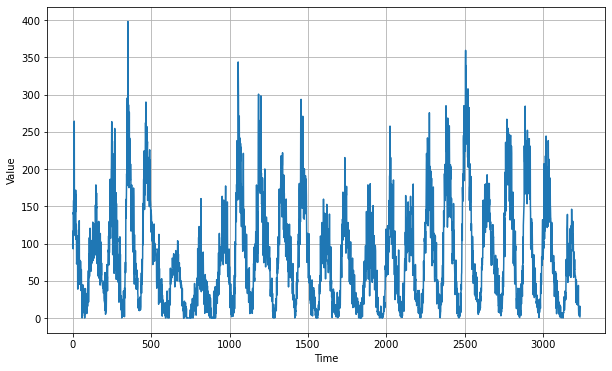

In [3]:
import numpy as np
import matplotlib.pyplot as plt

series = np.array(sunspots)
time = np.array(time_step)

plt.figure(figsize=(10, 6))
plt.plot(time, series)
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)

In [4]:
split_time = 3000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
import tensorflow as tf

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

tuning_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

tuning_optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
tuning_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tuning_optimizer,
              metrics=["mae"])
tuning_history = tuning_model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 2s 146ms/step - loss: 117.7029 - mae: 118.2027
Epoch 2/100
12/12 [==============================] - 2s 128ms/step - loss: 108.6016 - mae: 109.1011
Epoch 3/100
12/12 [==============================] - 2s 130ms/step - loss: 97.8251 - mae: 98.3237
Epoch 4/100
12/12 [==============================] - 2s 138ms/step - loss: 92.6459 - mae: 93.1443
Epoch 5/100
12/12 [==============================] - 2s 202ms/step - loss: 88.8275 - mae: 89.3260
Epoch 6/100
12/12 [==============================] - 2s 126ms/step - loss: 85.5169 - mae: 86.0155
Epoch 7/100
12/12 [==============================] - 2s 135ms/step - loss: 81.7158 - mae: 82.2143
Epoch 8/100
12/12 [==============================] - 2s 137ms/step - loss: 76.4021 - mae: 76.9005
Epoch 9/100
12/12 [==============================] - 2s 202ms/step - loss: 71.1717 - mae: 71.6700
Epoch 10/100
12/12 [==============================] - 2s 132ms/step - loss: 67.4899 - mae: 67.9881
Epoch 11/100
12

12/12 [==============================] - 3s 228ms/step - loss: 41.0790 - mae: 41.5760
Epoch 84/100
12/12 [==============================] - 1s 125ms/step - loss: 42.7236 - mae: 43.2212
Epoch 85/100
12/12 [==============================] - 2s 127ms/step - loss: 42.7511 - mae: 43.2487
Epoch 86/100
12/12 [==============================] - 2s 131ms/step - loss: 44.1580 - mae: 44.6551
Epoch 87/100
12/12 [==============================] - 2s 199ms/step - loss: 46.4942 - mae: 46.9917
Epoch 88/100
12/12 [==============================] - 2s 131ms/step - loss: 43.8527 - mae: 44.3500
Epoch 89/100
12/12 [==============================] - 3s 239ms/step - loss: 46.9113 - mae: 47.4087
Epoch 90/100
12/12 [==============================] - 4s 329ms/step - loss: 45.8690 - mae: 46.3664
Epoch 91/100
12/12 [==============================] - 4s 338ms/step - loss: 47.8000 - mae: 48.2979
Epoch 92/100
12/12 [==============================] - 4s 359ms/step - loss: 48.9100 - mae: 49.4075
Epoch 93/100
12/12 [===

(1e-08, 0.0001, 0.0, 60.0)

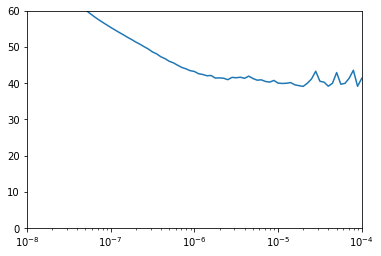

In [7]:
plt.semilogx(tuning_history.history["lr"], tuning_history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [8]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

tuned_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

tuned_optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

tuned_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tuned_optimizer,
              metrics=["mae"])
tuned_history = tuned_model.fit(train_set, epochs=500)

Epoch 1/500
30/30 [==============================] - 5s 166ms/step - loss: 50.1453 - mae: 50.6431
Epoch 2/500
30/30 [==============================] - 4s 136ms/step - loss: 42.6653 - mae: 43.1627
Epoch 3/500
30/30 [==============================] - 2s 80ms/step - loss: 40.7700 - mae: 41.2671
Epoch 4/500
30/30 [==============================] - 2s 75ms/step - loss: 40.5318 - mae: 41.0288
Epoch 5/500
30/30 [==============================] - 2s 75ms/step - loss: 39.8803 - mae: 40.3772
Epoch 6/500
30/30 [==============================] - 2s 74ms/step - loss: 39.3339 - mae: 39.8309
Epoch 7/500
30/30 [==============================] - 3s 86ms/step - loss: 40.7007 - mae: 41.1977
Epoch 8/500
30/30 [==============================] - 3s 94ms/step - loss: 40.4670 - mae: 40.9642
Epoch 9/500
30/30 [==============================] - 2s 74ms/step - loss: 42.2038 - mae: 42.7011
Epoch 10/500
30/30 [==============================] - 2s 73ms/step - loss: 41.2256 - mae: 41.7227
Epoch 11/500
30/30 [=======

30/30 [==============================] - 4s 131ms/step - loss: 32.5525 - mae: 33.0485
Epoch 85/500
30/30 [==============================] - 4s 136ms/step - loss: 31.5482 - mae: 32.0439
Epoch 86/500
30/30 [==============================] - 4s 139ms/step - loss: 31.7706 - mae: 32.2664
Epoch 87/500
30/30 [==============================] - 5s 150ms/step - loss: 31.4543 - mae: 31.9499
Epoch 88/500
30/30 [==============================] - 5s 153ms/step - loss: 31.8001 - mae: 32.2958
Epoch 89/500
30/30 [==============================] - 3s 115ms/step - loss: 31.2666 - mae: 31.7622
Epoch 90/500
30/30 [==============================] - 2s 71ms/step - loss: 31.2129 - mae: 31.7085
Epoch 91/500
30/30 [==============================] - 2s 77ms/step - loss: 31.1491 - mae: 31.6448
Epoch 92/500
30/30 [==============================] - 3s 105ms/step - loss: 31.7131 - mae: 32.2088
Epoch 93/500
30/30 [==============================] - 2s 72ms/step - loss: 31.7510 - mae: 32.2466
Epoch 94/500
30/30 [======

30/30 [==============================] - 2s 74ms/step - loss: 27.8434 - mae: 28.3385
Epoch 167/500
30/30 [==============================] - 3s 108ms/step - loss: 27.7764 - mae: 28.2714
Epoch 168/500
30/30 [==============================] - 3s 91ms/step - loss: 28.1037 - mae: 28.5990
Epoch 169/500
30/30 [==============================] - 3s 96ms/step - loss: 28.2712 - mae: 28.7664
Epoch 170/500
30/30 [==============================] - 3s 94ms/step - loss: 28.7990 - mae: 29.2944
Epoch 171/500
30/30 [==============================] - 3s 109ms/step - loss: 28.2021 - mae: 28.6971
Epoch 172/500
30/30 [==============================] - 4s 120ms/step - loss: 28.1233 - mae: 28.6183
Epoch 173/500
30/30 [==============================] - 4s 117ms/step - loss: 27.7400 - mae: 28.2349
Epoch 174/500
30/30 [==============================] - 2s 75ms/step - loss: 27.7645 - mae: 28.2594
Epoch 175/500
30/30 [==============================] - 2s 74ms/step - loss: 28.4718 - mae: 28.9670
Epoch 176/500
30/30 

30/30 [==============================] - 3s 108ms/step - loss: 26.3328 - mae: 26.8273
Epoch 248/500
30/30 [==============================] - 3s 91ms/step - loss: 26.1672 - mae: 26.6618
Epoch 249/500
30/30 [==============================] - 3s 100ms/step - loss: 25.7180 - mae: 26.2125
Epoch 250/500
30/30 [==============================] - 3s 103ms/step - loss: 25.6162 - mae: 26.1105
Epoch 251/500
30/30 [==============================] - 3s 85ms/step - loss: 25.6513 - mae: 26.1456
Epoch 252/500
30/30 [==============================] - 2s 82ms/step - loss: 25.7654 - mae: 26.2600
Epoch 253/500
30/30 [==============================] - 3s 116ms/step - loss: 25.9041 - mae: 26.3987
Epoch 254/500
30/30 [==============================] - 2s 76ms/step - loss: 25.3006 - mae: 25.7950
Epoch 255/500
30/30 [==============================] - 2s 77ms/step - loss: 25.5951 - mae: 26.0895
Epoch 256/500
30/30 [==============================] - 3s 101ms/step - loss: 26.0369 - mae: 26.5313
Epoch 257/500
30/30

30/30 [==============================] - 3s 96ms/step - loss: 25.3100 - mae: 25.8042
Epoch 330/500
30/30 [==============================] - 3s 89ms/step - loss: 25.1779 - mae: 25.6725
Epoch 331/500
30/30 [==============================] - 3s 98ms/step - loss: 24.3068 - mae: 24.8010
Epoch 332/500
30/30 [==============================] - 3s 105ms/step - loss: 24.3178 - mae: 24.8120
Epoch 333/500
30/30 [==============================] - 3s 108ms/step - loss: 24.5127 - mae: 25.0070
Epoch 334/500
30/30 [==============================] - 3s 106ms/step - loss: 24.8030 - mae: 25.2977
Epoch 335/500
30/30 [==============================] - 3s 102ms/step - loss: 25.6547 - mae: 26.1494
Epoch 336/500
30/30 [==============================] - 3s 101ms/step - loss: 25.5428 - mae: 26.0374
Epoch 337/500
30/30 [==============================] - 3s 99ms/step - loss: 24.6975 - mae: 25.1919
Epoch 338/500
30/30 [==============================] - 3s 112ms/step - loss: 24.5773 - mae: 25.0715
Epoch 339/500
30/3

Epoch 410/500
30/30 [==============================] - 2s 83ms/step - loss: 23.2287 - mae: 23.7223
Epoch 411/500
30/30 [==============================] - 3s 85ms/step - loss: 22.8991 - mae: 23.3926: 1s - loss: 22.8746
Epoch 412/500
30/30 [==============================] - 3s 93ms/step - loss: 23.5670 - mae: 24.0606
Epoch 413/500
30/30 [==============================] - 3s 87ms/step - loss: 23.7309 - mae: 24.2250
Epoch 414/500
30/30 [==============================] - 3s 88ms/step - loss: 23.6750 - mae: 24.1692
Epoch 415/500
30/30 [==============================] - 2s 82ms/step - loss: 22.8756 - mae: 23.3692
Epoch 416/500
30/30 [==============================] - 2s 82ms/step - loss: 23.9244 - mae: 24.4184
Epoch 417/500
30/30 [==============================] - 2s 81ms/step - loss: 23.4705 - mae: 23.9642
Epoch 418/500
30/30 [==============================] - 2s 82ms/step - loss: 23.8148 - mae: 24.3087
Epoch 419/500
30/30 [==============================] - 2s 82ms/step - loss: 23.4035 - mae

30/30 [==============================] - 2s 80ms/step - loss: 22.7879 - mae: 23.2815
Epoch 492/500
30/30 [==============================] - 2s 80ms/step - loss: 22.2428 - mae: 22.7361
Epoch 493/500
30/30 [==============================] - 3s 85ms/step - loss: 22.1100 - mae: 22.6030
Epoch 494/500
30/30 [==============================] - 3s 87ms/step - loss: 22.6237 - mae: 23.1174
Epoch 495/500
30/30 [==============================] - 3s 88ms/step - loss: 22.2897 - mae: 22.7831
Epoch 496/500
30/30 [==============================] - 3s 85ms/step - loss: 22.0746 - mae: 22.5679
Epoch 497/500
30/30 [==============================] - 3s 84ms/step - loss: 22.0202 - mae: 22.5133
Epoch 498/500
30/30 [==============================] - 3s 84ms/step - loss: 22.4145 - mae: 22.9079
Epoch 499/500
30/30 [==============================] - 3s 91ms/step - loss: 23.4272 - mae: 23.9211
Epoch 500/500
30/30 [==============================] - 3s 83ms/step - loss: 22.8952 - mae: 23.3889


In [9]:
ds = tf.data.Dataset.from_tensor_slices(series[..., np.newaxis])
ds = ds.window(window_size, shift=1, drop_remainder=True)
ds = ds.flat_map(lambda w: w.batch(window_size))
ds = ds.batch(32).prefetch(1)
rnn_forecast = tuned_model.predict(ds)

rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

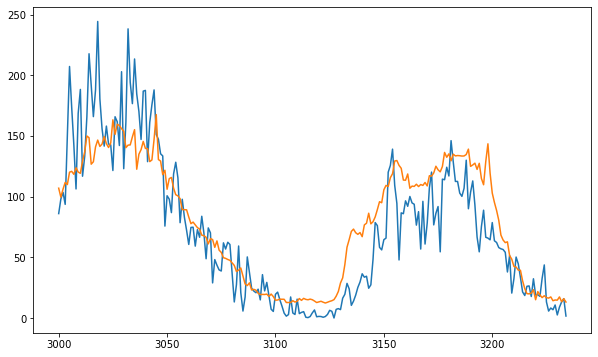

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, rnn_forecast)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

22.155107

<Figure size 432x288 with 0 Axes>

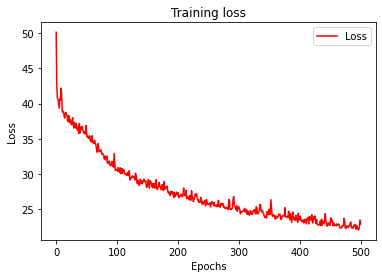

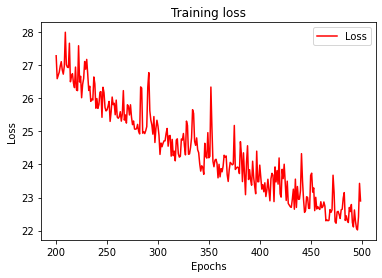

<Figure size 432x288 with 0 Axes>

In [14]:
loss = tuned_history.history["loss"]

epochs=range(len(loss))

zoomed_loss = loss[200:]
zoomed_epochs = range(200, 500)

plt.plot(epochs, loss, "r")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

plt.plot(zoomed_epochs, zoomed_loss, "r")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()